In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read data

In [33]:
results_dir = "Coweeta-2023-11-23"

home_dir = r"G:\Shared drives\Ryoko and Hilary\SMSigxModel\analysis"
input_dir = os.path.join(home_dir, "3_GLUE_prerun", "results", results_dir)
output_dir = os.path.join(home_dir, "3_GLUE_prerun", "results", "GLUE_pre",results_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

senario_names = ['KGE on Flow', 'KGE on Soil Moisture', 'KGE on seasonal transition', 'KGE on Flow + KGE on Soil Moisture', 'KGE on Flow + Seasonal Timing on Soil Moisture']
senario_short_names = ['Reference', 'None', 'None', 'SM magnitude', 'SM timings']

In [34]:
df = pd.read_csv(os.path.join(input_dir, 'evaluation_metrics.csv'), index_col=0)
df.head()
df['bias_in_seasonsig_dates_max'] = df[['SeasonTrans of Soil dry2wet_start','SeasonTrans of Soil dry2wet_end','SeasonTrans of Soil wet2dry_start','SeasonTrans of Soil wet2dry_end']].max(axis='columns')
# results_tot_metrics

In [35]:
df.columns

Index(['NSE on Flow', 'NSE on Soil', 'KGE on Flow', 'KGE on Soil',
       'SeasonTrans of Soil dry2wet_start', 'SeasonTrans of Soil dry2wet_end',
       'SeasonTrans of Soil wet2dry_start', 'SeasonTrans of Soil wet2dry_end',
       'bias_in_seasonsig_dates_max'],
      dtype='object')

# Check how many runs were behavioral

In [36]:
def is_behavioral(value, criteria, comparison_type):
    if comparison_type == 'greater':
        return value > criteria
    elif comparison_type == 'less':
        return value < criteria

# ... similarly define for other metrics
criteria_dict = {
    'KGE on Flow': {'criteria': 0.5, 'comparison_type': 'greater'},
    'KGE on Soil': {'criteria': 0.5, 'comparison_type': 'greater'},
    'SeasonTrans of Soil dry2wet_start': {'criteria': 30, 'comparison_type': 'less'},
    'SeasonTrans of Soil dry2wet_end': {'criteria': 30, 'comparison_type': 'less'},
    'SeasonTrans of Soil wet2dry_start': {'criteria': 30, 'comparison_type': 'less'},
    'SeasonTrans of Soil wet2dry_end': {'criteria': 30, 'comparison_type': 'less'},
    'bias_in_seasonsig_dates_max': {'criteria': 30, 'comparison_type': 'less'}
    # Add other columns and their criteria here
}

# Apply these criteria to create new columns
for column, info in criteria_dict.items():
    criteria = info['criteria']
    comparison_type = info['comparison_type']
    new_column_name = f'{column}_Behavioral'
    df[new_column_name] = df[column].apply(lambda x: is_behavioral(x, criteria, comparison_type))
    # Print the count of 'True' values for each new column
    true_count = df[new_column_name].sum()
    print(f"Number of behavioral runs {column}: {true_count}")

Number of behavioral runs KGE on Flow: 923
Number of behavioral runs KGE on Soil: 4822
Number of behavioral runs SeasonTrans of Soil dry2wet_start: 9175
Number of behavioral runs SeasonTrans of Soil dry2wet_end: 6223
Number of behavioral runs SeasonTrans of Soil wet2dry_start: 9680
Number of behavioral runs SeasonTrans of Soil wet2dry_end: 9686
Number of behavioral runs bias_in_seasonsig_dates_max: 6087


In [37]:
true_count = ((df['KGE on Soil_Behavioral'] == True) & (df['KGE on Flow_Behavioral'] == True)).sum()
print(f"Number of behavioral runs both KGE Flow & SM: {true_count}")


Number of behavioral runs both KGE Flow & SM: 468


# Plot the intersection of two criteria

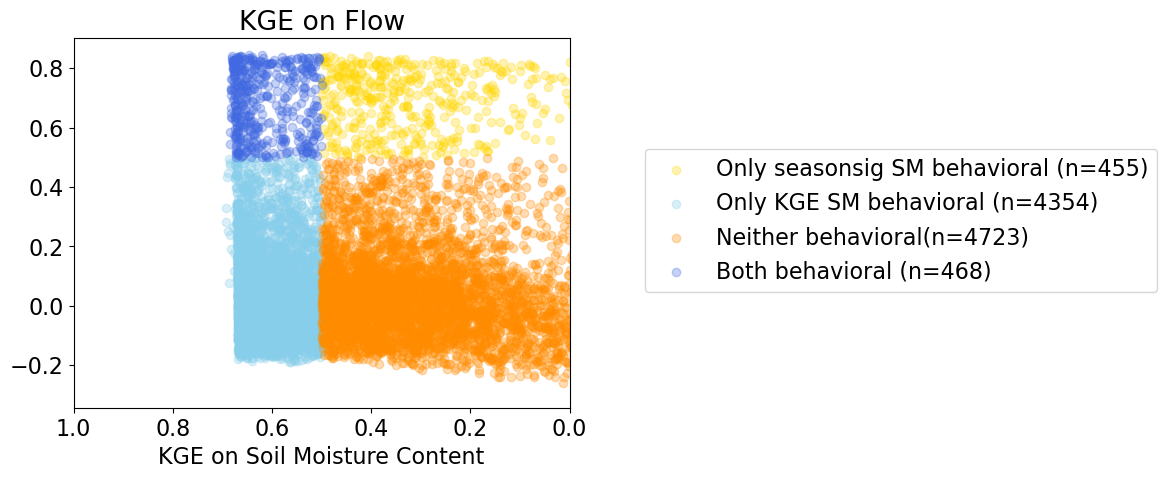

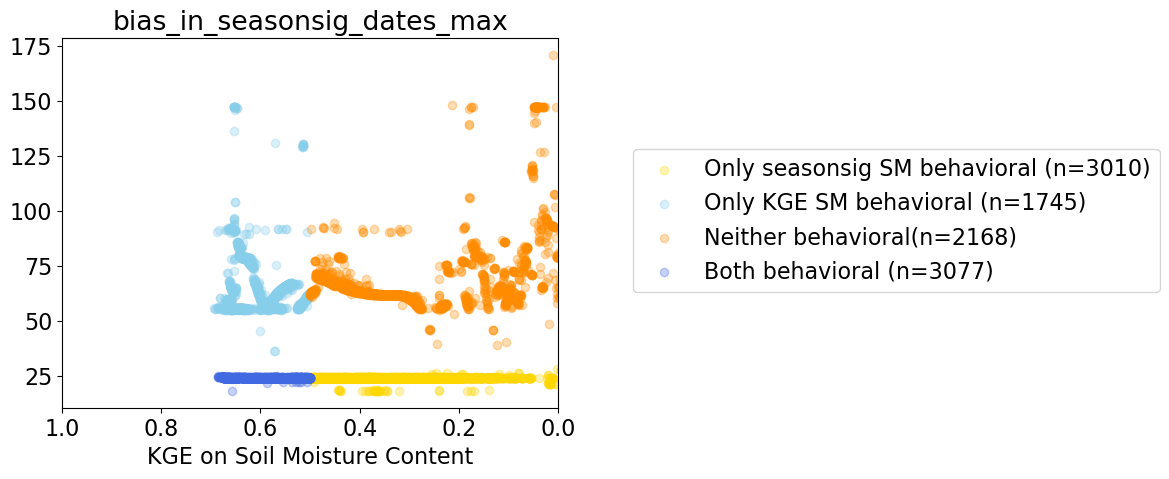

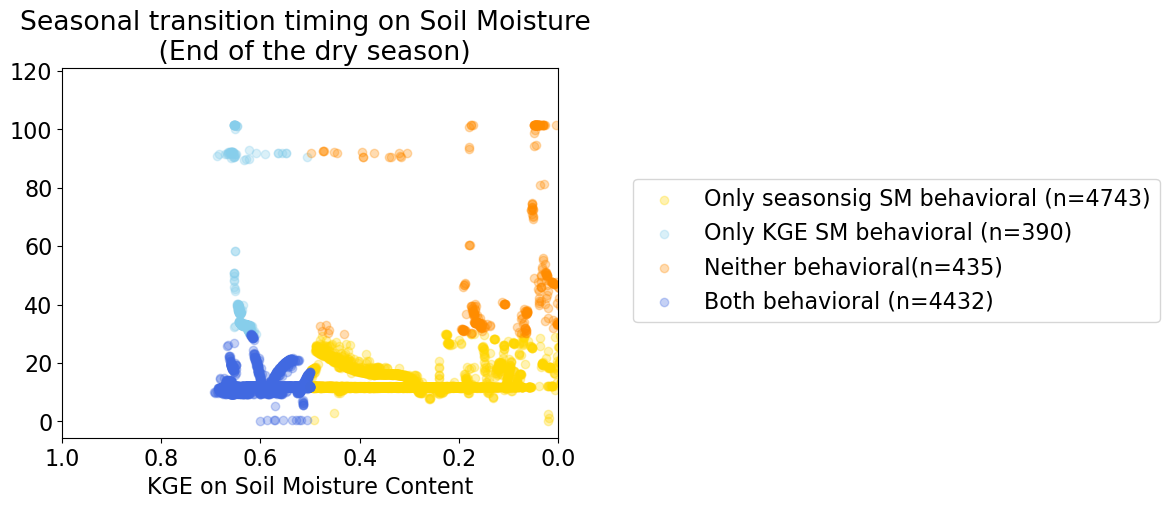

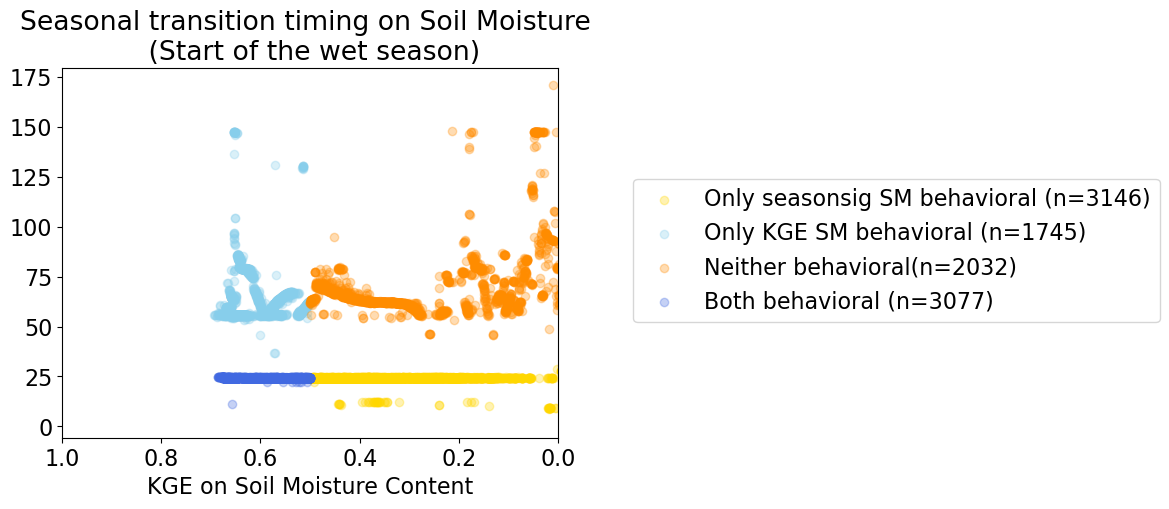

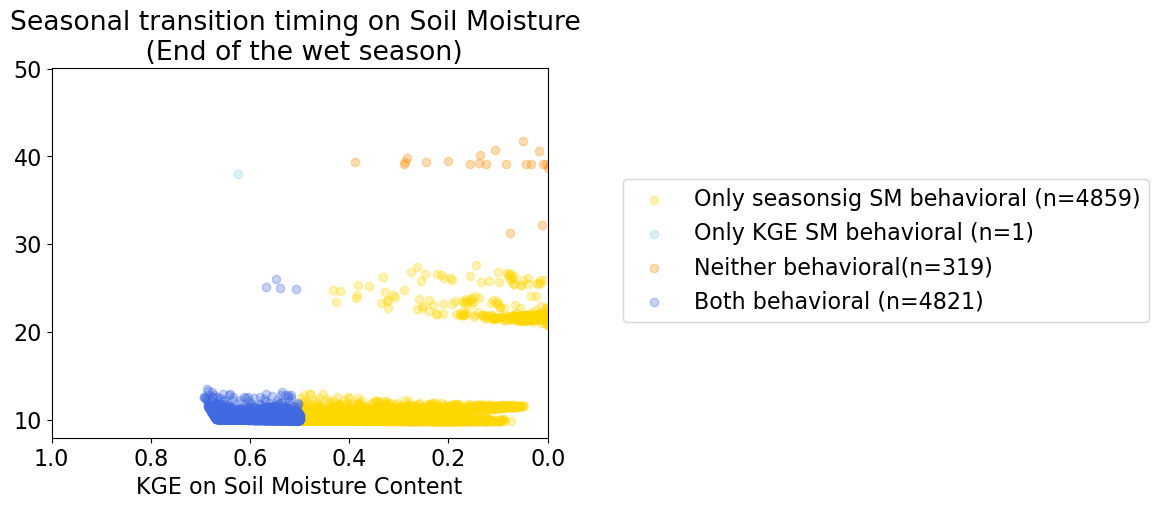

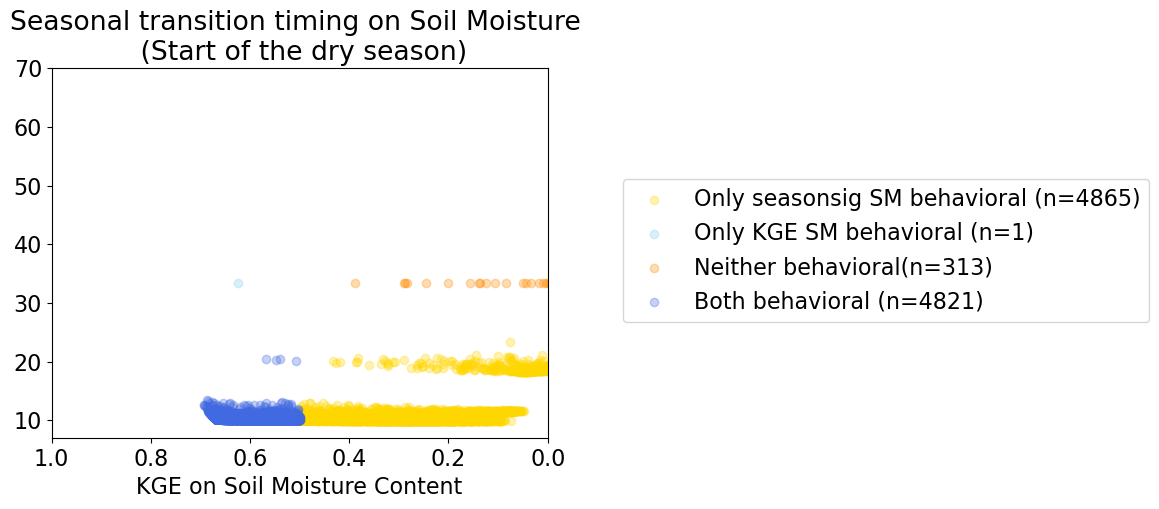

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming results_tot_metrics is your new DataFrame with the _Behavioral columns added
# And out_path is defined as the directory where you want to save your figures

# Define your figure titles and variables as before
fig_titles = [
        'KGE on Flow',
    'bias_in_seasonsig_dates_max',
    'Seasonal transition timing on Soil Moisture \n (End of the dry season)', 
    'Seasonal transition timing on Soil Moisture \n (Start of the wet season)', 
    'Seasonal transition timing on Soil Moisture \n (End of the wet season)', 
    'Seasonal transition timing on Soil Moisture \n (Start of the dry season)'
]

seasonsig_SM_vars = [
    'KGE on Flow',
    'bias_in_seasonsig_dates_max', 
    'SeasonTrans of Soil dry2wet_start', 
    'SeasonTrans of Soil dry2wet_end', 
    'SeasonTrans of Soil wet2dry_start', 
    'SeasonTrans of Soil wet2dry_end'
]

# Loop through your variables and create plots
for i, seasonsig_var in enumerate(seasonsig_SM_vars):
    fig, ax = plt.subplots()
    x = df['KGE on Soil'].values
    y = df[seasonsig_var].values
    
    # Use the new behavioral columns
    x_behavioral = df['KGE on Soil_Behavioral'].values
    y_behavioral = df[f'{seasonsig_var}_Behavioral'].values
    
    x_and_y_behavioral = np.logical_and(x_behavioral, y_behavioral)
    only_y_behavioral = np.logical_and(y_behavioral, np.logical_not(x_behavioral))
    only_x_behavioral = np.logical_and(x_behavioral, np.logical_not(y_behavioral))
    neither_behavioral = np.logical_not(np.logical_or(x_behavioral, y_behavioral))
    
    # Plot each category with its respective color and label
    plt.scatter(x[only_y_behavioral], y[only_y_behavioral], alpha=0.3, color='gold', label=f'Only seasonsig SM behavioral (n={np.count_nonzero(only_y_behavioral)})')
    plt.scatter(x[only_x_behavioral], y[only_x_behavioral], alpha=0.3, color='skyblue', label=f'Only KGE SM behavioral (n={np.count_nonzero(only_x_behavioral)})')
    plt.scatter(x[neither_behavioral], y[neither_behavioral], alpha=0.3, color='darkorange', label=f'Neither behavioral(n={np.count_nonzero(neither_behavioral)})')
    plt.scatter(x[x_and_y_behavioral], y[x_and_y_behavioral], alpha=0.3, color='royalblue', label=f'Both behavioral (n={np.count_nonzero(x_and_y_behavioral)})')
    
    # Set labels, limits, title, and invert x-axis as in the original code
    ax.set_xlabel('KGE on Soil Moisture Content')
    ax.set_xlim([0, 1])
    # ax.set_ylabel('Mean absolute differences in transition dates [days]')
    # ax.set_ylim([0, 60])
    ax.set_title(fig_titles[i])
    ax.invert_xaxis()
    
    # Create a legend and save the figure
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # fig.savefig(os.path.join(out_path, f'seasonsig_{seasonsig_var}.png'), bbox_inches='tight')
    
    # plt.close(fig)  # Close the figure to avoid displaying it in a notebook environment


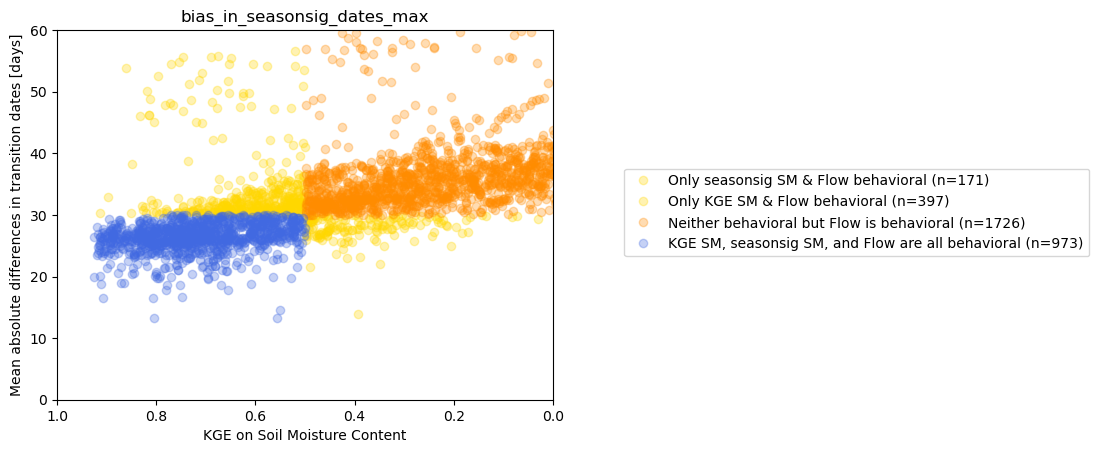

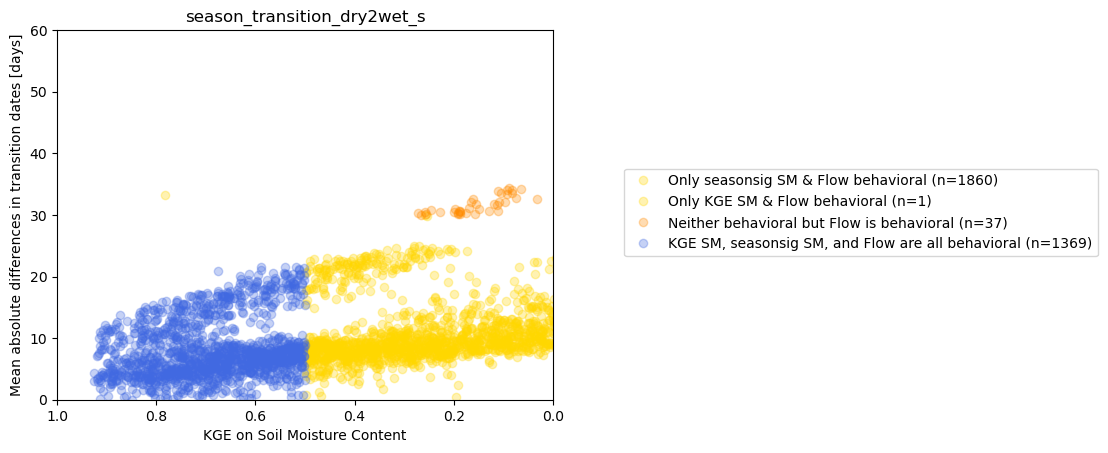

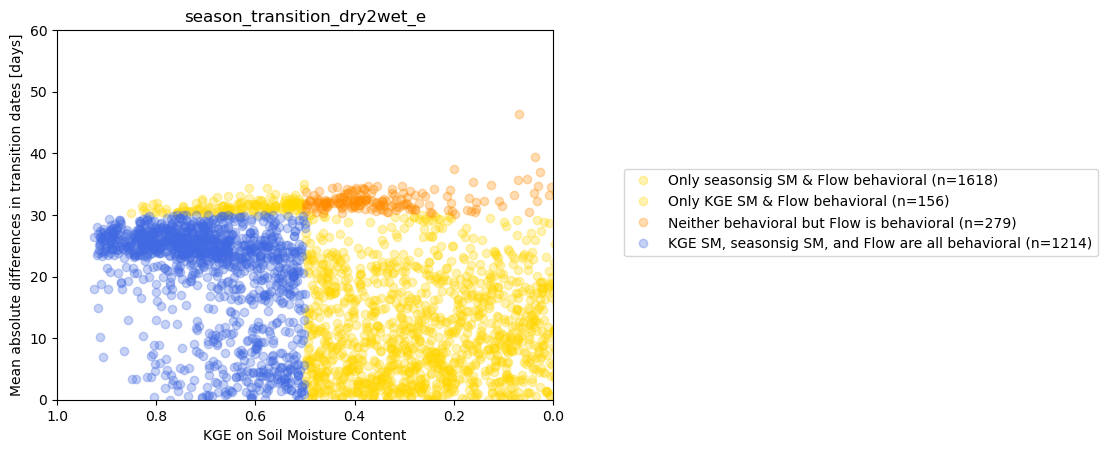

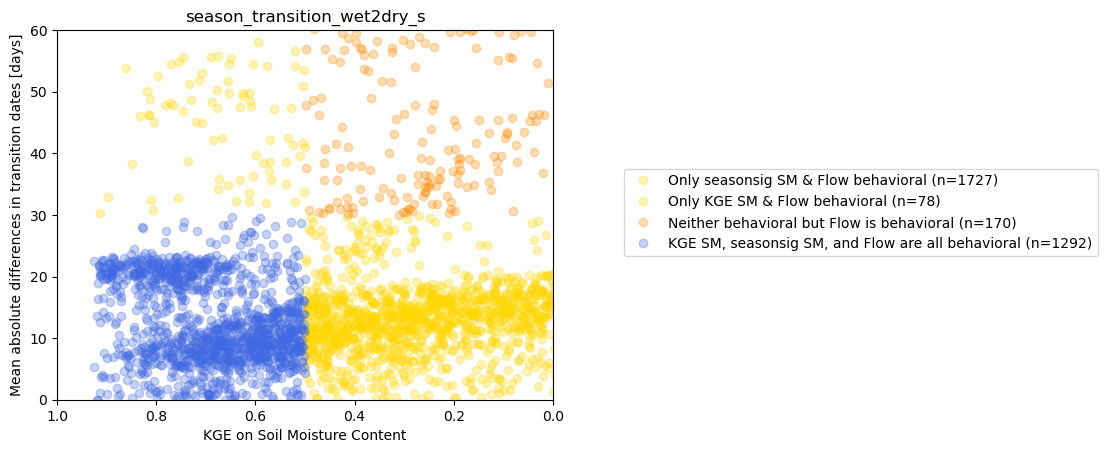

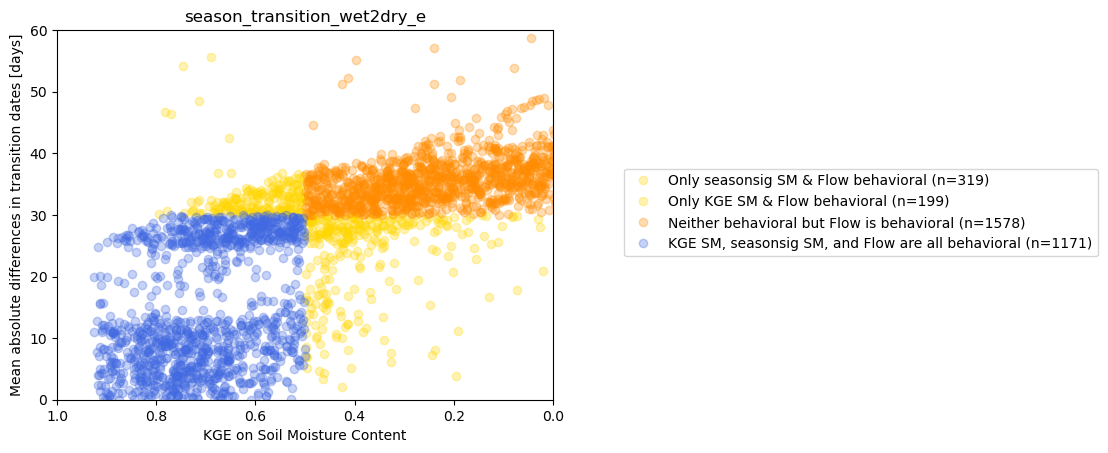

In [72]:

# Assuming results_tot_metrics is your new DataFrame with the _Behavioral columns added
# And out_path is defined as the directory where you want to save your figures

# Define your figure titles and variables as before
fig_titles = [
        'KGE on Soil',
    'bias_in_seasonsig_dates_max',
    'Seasonal transition timing on Soil Moisture \n (End of the dry season)', 
    'Seasonal transition timing on Soil Moisture \n (Start of the wet season)', 
    'Seasonal transition timing on Soil Moisture \n (End of the wet season)', 
    'Seasonal transition timing on Soil Moisture \n (Start of the dry season)'
]

seasonsig_SM_vars = [
    'KGE on Soil',
    'bias_in_seasonsig_dates_max', 
    'SeasonTrans of Soil dry2wet_start', 
    'SeasonTrans of Soil dry2wet_end', 
    'SeasonTrans of Soil wet2dry_start', 
    'SeasonTrans of Soil wet2dry_end'
]

# Loop through your variables and create plots
for i, seasonsig_var in enumerate(seasonsig_SM_vars):
    fig, ax = plt.subplots()
    x = df['KGE on Flow'].values
    y = df[seasonsig_var].values
    
    # Use the new behavioral columns
    x_behavioral = df['KGE on Flow_Behavioral'].values
    y_behavioral = df[f'{seasonsig_var}_Behavioral'].values
    
    x_and_y_behavioral = np.logical_and(x_behavioral, y_behavioral)
    only_y_behavioral = np.logical_and(y_behavioral, np.logical_not(x_behavioral))
    only_x_behavioral = np.logical_and(x_behavioral, np.logical_not(y_behavioral))
    neither_behavioral = np.logical_not(np.logical_or(x_behavioral, y_behavioral))
    
    # Plot each category with its respective color and label
    plt.scatter(x[only_y_behavioral], y[only_y_behavioral], alpha=0.3, color='gold', label=f'Only seasonsig SM behavioral (n={np.count_nonzero(only_y_behavioral)})')
    plt.scatter(x[only_x_behavioral], y[only_x_behavioral], alpha=0.3, color='skyblue', label=f'Only KGE Flow behavioral (n={np.count_nonzero(only_x_behavioral)})')
    plt.scatter(x[neither_behavioral], y[neither_behavioral], alpha=0.3, color='darkorange', label=f'Neither behavioral(n={np.count_nonzero(neither_behavioral)})')
    plt.scatter(x[x_and_y_behavioral], y[x_and_y_behavioral], alpha=0.3, color='royalblue', label=f'Both behavioral (n={np.count_nonzero(x_and_y_behavioral)})')
    
    # Set labels, limits, title, and invert x-axis as in the original code
    ax.set_xlabel('KGE on Soil Moisture Content')
    ax.set_xlim([0, 1])
    # ax.set_ylabel('Mean absolute differences in transition dates [days]')
    # ax.set_ylim([0, 60])
    ax.set_title(fig_titles[i])
    ax.invert_xaxis()
    
    # Create a legend and save the figure
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # fig.savefig(os.path.join(out_path, f'seasonsig_{seasonsig_var}.png'), bbox_inches='tight')
    
    # plt.close(fig)  # Close the figure to avoid displaying it in a notebook environment


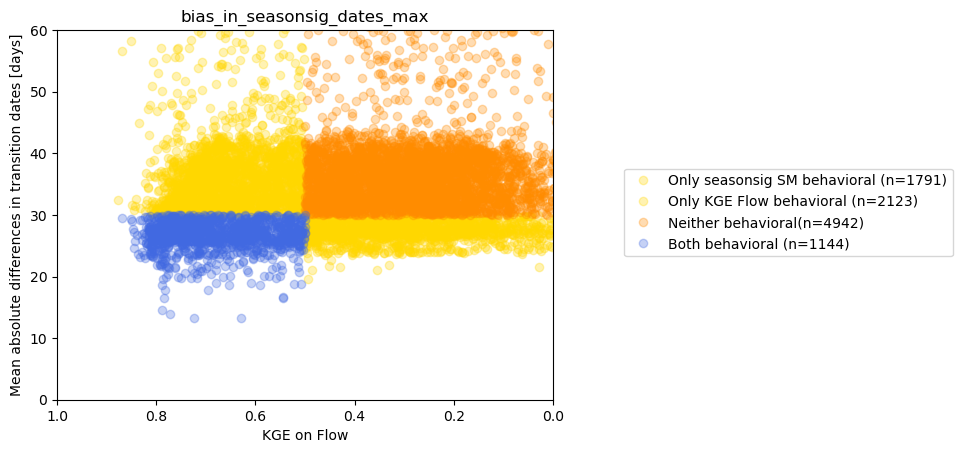

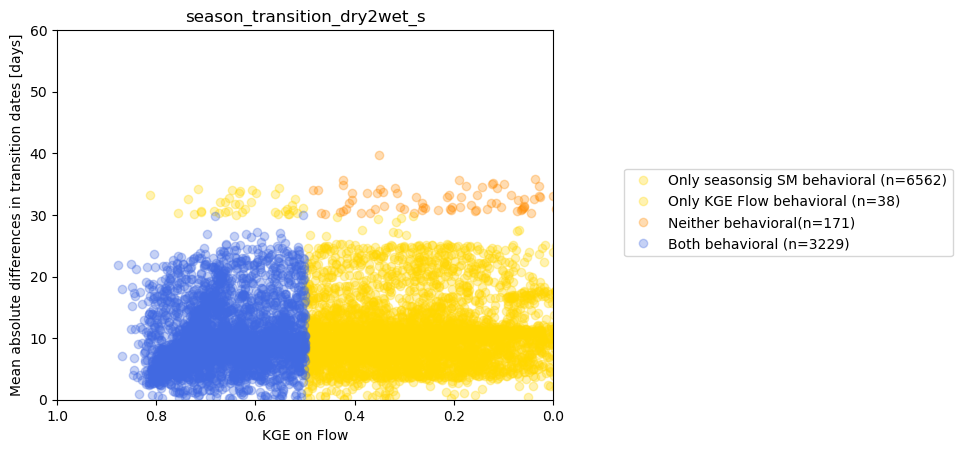

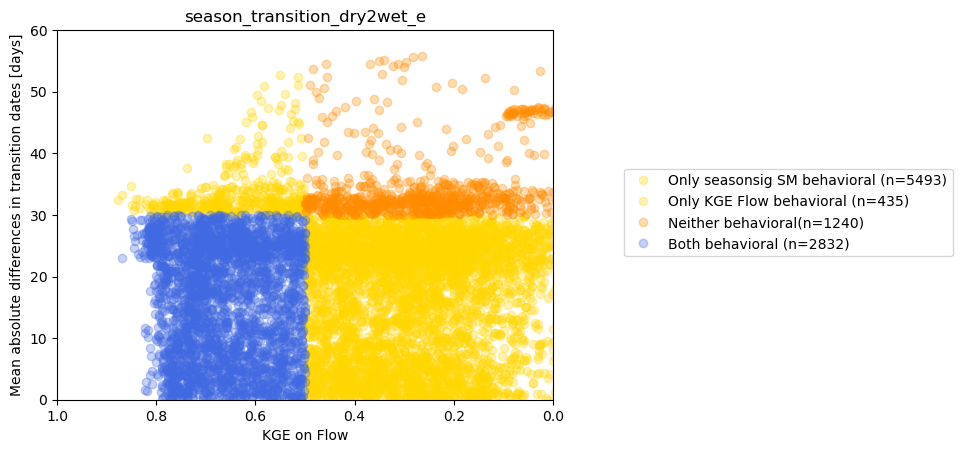

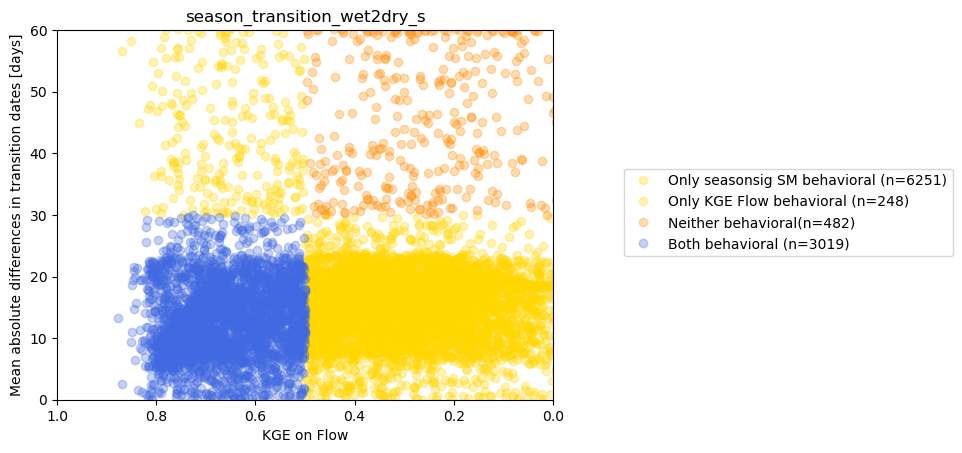

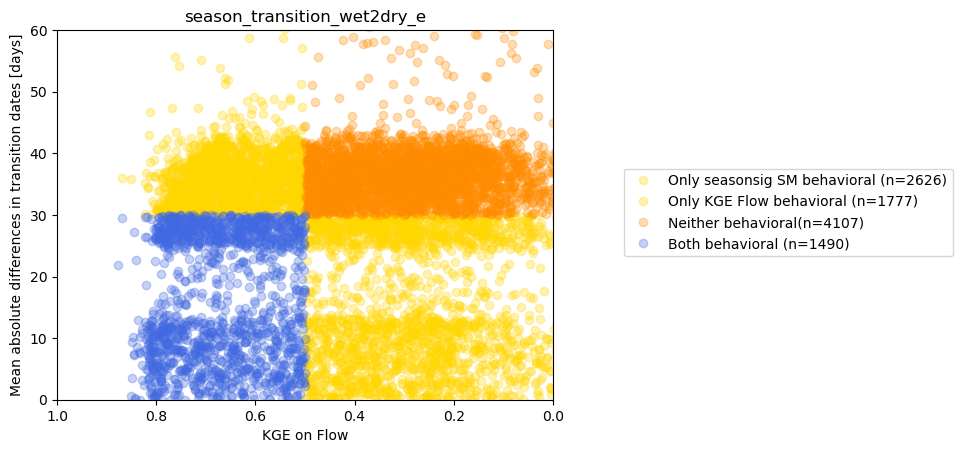

In [69]:
fig_title = ['KGE on Flow', 'KGE on Soil Moisture Content', 'Seasonal transition timing on Soil Moisture \n (End of the dry season)', 'Seasonal transition timing on Soil Moisture \n (Start of the wet season)', 
            'Seasonal transition timing on Soil Moisture \n (End of the wet season)', 'Seasonal transition timing on Soil Moisture \n (Start of the dry season)']
# colors = ['#BCBCBC', '#3388B6', '#3388B6', '#3388B6', '#FF993E']
seasonsig_SM_vars = ['bias_in_seasonsig_dates_max', 'season_transition_dry2wet_s', 'season_transition_dry2wet_e', 'season_transition_wet2dry_s', 'season_transition_wet2dry_e']
for i, seasonsig_var in enumerate(seasonsig_SM_vars):
    fig, ax = plt.subplots()
    x = results_tot_metrics['KGE on Flow'].values
    x_behavioral = results_tot_metrics['KGE on Flow'].values > 0.5
    y = results_tot_metrics[seasonsig_var].values
    y_behavioral = results_tot_metrics[seasonsig_var].values < 30
    
    x_and_y_behavioral = np.logical_and(x_behavioral, y_behavioral)
    only_y_behavioral = np.logical_and(y_behavioral, np.logical_not(x_behavioral))
    only_x_behavioral = np.logical_and(x_behavioral, np.logical_not(y_behavioral))
    neither_behavioral = np.logical_and(np.logical_not(x_behavioral), np.logical_not(y_behavioral))
    
    
    plt.plot(x[only_y_behavioral], y[only_y_behavioral], 'o', alpha=0.3, color='gold', label=f'Only seasonsig SM behavioral (n={np.count_nonzero(only_y_behavioral)})')
    plt.plot(x[only_x_behavioral], y[only_x_behavioral], 'o', alpha=0.3, color='gold', label=f'Only KGE Flow behavioral (n={np.count_nonzero(only_x_behavioral)})')
    plt.plot(x[neither_behavioral], y[neither_behavioral], 'o', alpha=0.3, color='darkorange', label=f'Neither behavioral(n={np.count_nonzero(neither_behavioral)})')
    plt.plot(x[x_and_y_behavioral], y[x_and_y_behavioral], 'o', alpha=0.3, color='royalblue', label=f'Both behavioral (n={np.count_nonzero(x_and_y_behavioral)})')
    
    ax.set_xlabel('KGE on Flow')
    ax.set_xlim([0, 1])
    ax.set_ylabel('Mean absolute differences in transition dates [days]')
    ax.set_ylim([0, 60])
    ax.set_title(seasonsig_var)
    ax.invert_xaxis()
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.savefig(os.path.join(out_path, f'seasonsig_{seasonsig_var}.png'))